In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<class 'int'>
<class 'datetime.date'>


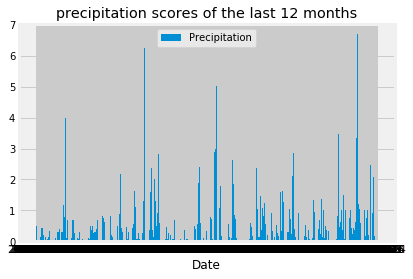

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastDate_str = session.query(func.max(Measurement.date).label('lastDate')).one().lastDate   
from datetime import datetime,date
lastDate_date = datetime.strptime(lastDate_str, '%Y-%m-%d')
year=lastDate_date.year
month=lastDate_date.month
day=lastDate_date.day
print(type(year))
Oneyearago_date = date(year=year-1,month=month,day=day)
# Oneyearago_date = datetime.date(year=year-1,month=month,day=day) # ???TypeError: descriptor 'date' of 'datetime.datetime' object needs an argument
print(type(Oneyearago_date))
# Perform a query to retrieve the date and precipitation scores of the last 12 months
prcpdata_list = session.query(Measurement.date,Measurement.prcp).filter((Measurement.date>Oneyearago_date)&(Measurement.date<lastDate_str)).all()
# print(prcpdata_list)
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdata_df = pd.DataFrame(prcpdata_list, columns=['date','precipitation'])
# prcpdata_df.set_index('date', inplace=True) # after set 'date' as index can index be used as x axis?????
# Sort the dataframe by date
prcpdata_df.sort_values(['date'], ascending = False,inplace = True) 
# Use Pandas Plotting with Matplotlib to plot the data   # use which to plot??????????
plt.xlabel('Date')   # TypeError: 'str' object is not callable: Re-starting the kernel or re-importing the libraries restores plt.ylabel to a function. 
# plt.ylabel('Precipitation')
import matplotlib.pyplot as plt  # restart kernal!!!!!!!!!!!!
plt.title('precipitation scores of the last 12 months')
plt.bar(prcpdata_df['date'],prcpdata_df['precipitation'],label="Precipitation")
plt.legend(loc="upper center")
# plt.tight_layout()
plt.show()             

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata_df.describe()

,precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stationcount = session.query(func.count(func.distinct(Measurement.station))).scalar()
print(stationcount)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationrowcounts_list = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stationrowcounts_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result_tuple = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').one()
lowesttempatureofmostactivestation = result_tuple[0]
highesttempatureofmostactivestation = result_tuple[1]
averagetempatureofmostactivestation = result_tuple[2]
print(lowesttempatureofmostactivestation,highesttempatureofmostactivestation,averagetempatureofmostactivestation)


54.0 85.0 71.66378066378067


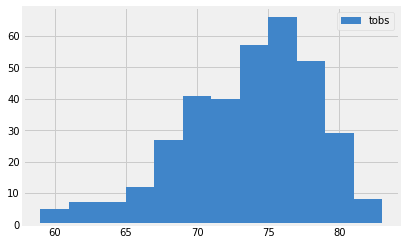

In [15]:
# Choose the station with the highest number of temperature observations.
subq = session.query(Measurement.station, func.count(Measurement.id).label('idcount')).group_by(Measurement.station).subquery('t2')
query = session.query(Measurement.station, func.max(subq.c.idcount)).join(subq,Measurement.station == subq.c.station)
mostactivestation = query.one()[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsdata_tupplelist = session.query(Measurement.tobs).filter(Measurement.station == mostactivestation).filter((Measurement.date>Oneyearago_date)&(Measurement.date<lastDate_str)).all()
tobsdata_list = list(np.ravel(tobsdata_tupplelist))

plt.xlabel="Temperature"   
plt.ylabel="Frequency"
plt.title="last 12 months temperatures of most active station"
plt.hist(tobsdata_list, bins=12, color="#4085c9",orientation="vertical", label="tobs")  
plt.legend()   
plt.show()


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_tupplelist = calc_temps(Oneyearago_date,lastDate_str)
temps_list = list(np.ravel(temps_tupplelist))

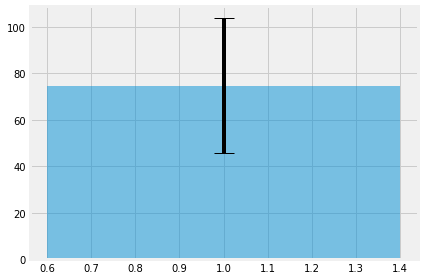

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yvalue = temps_list[1]
ptp=temps_list[2]-temps_list[0] 
yer = np.std(ptp)

plt.bar(1, yvalue, yerr=ptp, align='center', alpha=0.5, ecolor='black', capsize=10)
# plt.ylabel('Temp(F)')
# plt.title('Trip Avg Temp')

plt.tight_layout()
plt.show()


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sele = [func.sum(Measurement.tobs).label("stationsumtobs"),Measurement.station]
subq= session.query(*sele).filter((Measurement.date>=Oneyearago_date)&(Measurement.date<=lastDate_str)).group_by(Measurement.station).order_by(func.sum(Measurement.tobs).desc()).subquery('t2')
sele = [Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,subq.c.stationsumtobs ]
query = session.query(*sele).filter(subq.c.station==Station.station)   
for r in query:  
    print(r.id, r.station, r.name, r.latitude, r.longitude, r.elevation, r.stationsumtobs ) 

1 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0 27151.0
2 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6 25134.0
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0 23534.0
4 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9 13685.0
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5 25939.0
7 USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9 25734.0
9 USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4 25160.0
